Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 50, 50, 3)]      0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                                
                                                           

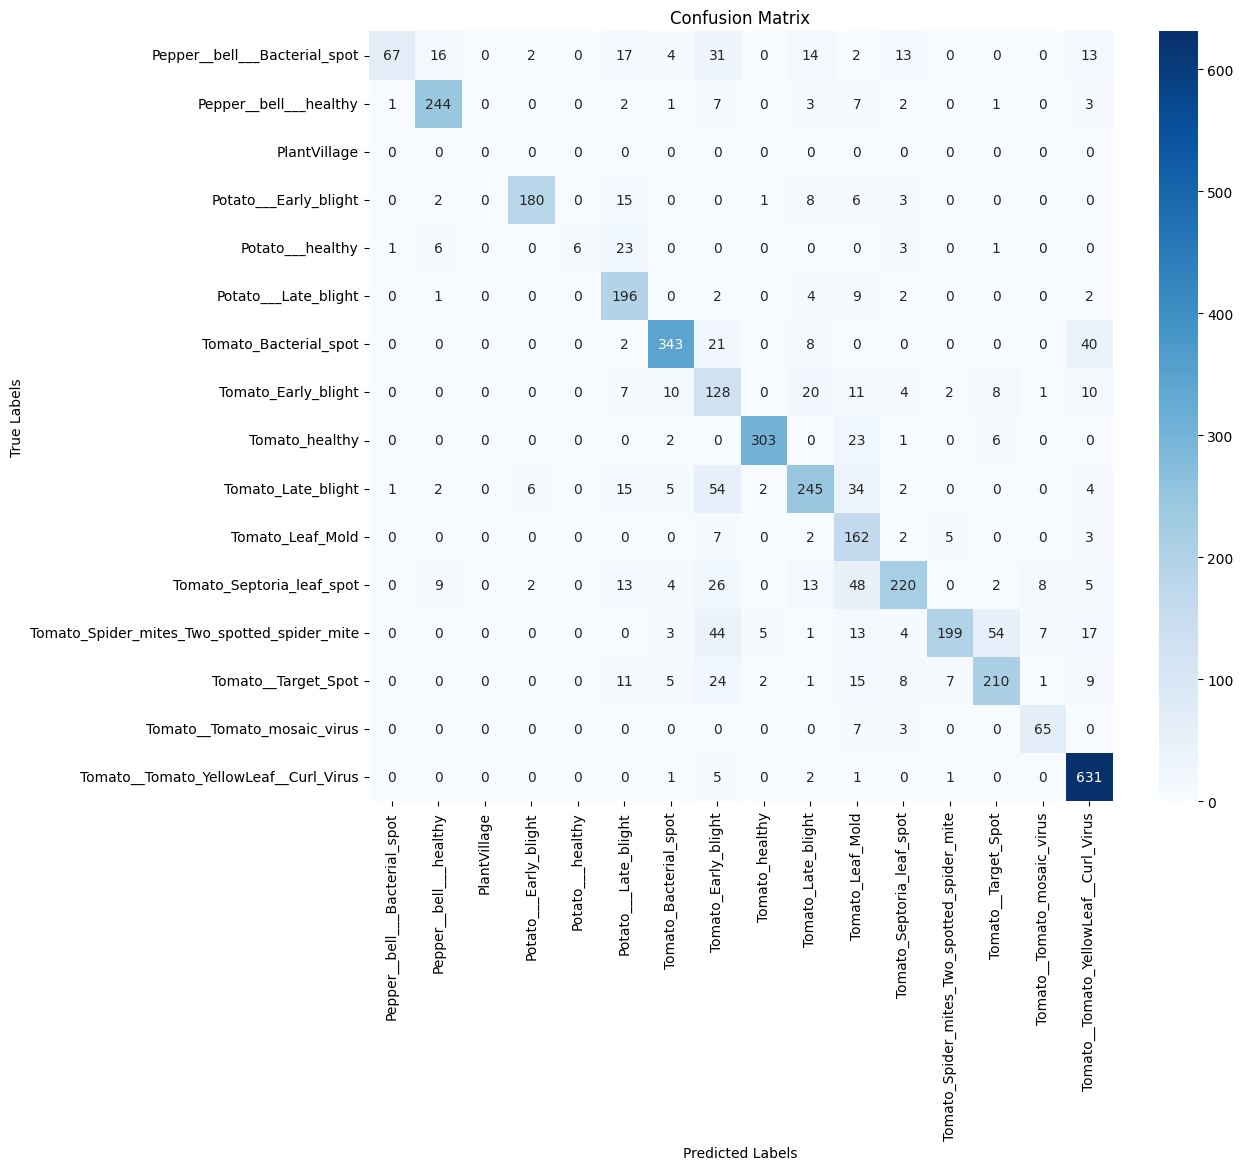

129/129 [==============================] - 12s 95ms/step
Overall Accuracy: 1.0
1/1 [==============================] - 0s 219ms/step
Predicted class: Tomato_Late_blight


In [4]:

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn import preprocessing
#from keras.utils import to_categoricalP
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the path to the PlantVillage dataset
dataset_path = "C:\\Users\\Cyril\\OneDrive\\Desktop\\Data Science\\PlantVillage"

# Load the classes (labels)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# Initialize lists for storing images and labels
images = []
labels = []

# Load the images and labels
for class_id, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (50, 50))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(class_id)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and test datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values to between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Define the CNN model architecture
activation = 'sigmoid'
feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation=activation, padding='same', input_shape=(50, 50, 3)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(Conv2D(32, 3, activation=activation, padding='same', kernel_initializer='he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())
feature_extractor.add(Conv2D(64, 3, activation=activation, padding='same', kernel_initializer='he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(Conv2D(64, 3, activation=activation, padding='same', kernel_initializer='he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())
feature_extractor.add(Flatten())
x = feature_extractor.output  
x = Dense(128, activation=activation, kernel_initializer='he_uniform')(x)
prediction_layer = Dense(num_classes, activation='softmax')(x)
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

# Train the CNN model
#history = cnn_model.fit(x_train, y_train_one_hot,pochs=4, validation_data=(x_test, y_test_one_hot))

# Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot,epochs=5 ,validation_data=(x_test, y_test_one_hot), verbose=1)

# Get the overall training and validation accuracy and loss
overall_loss = history.history['loss'][-1]
overall_val_loss = history.history['val_loss'][-1]
overall_acc = history.history['accuracy'][-1]
overall_val_acc = history.history['val_accuracy'][-1]

print("Overall Training Loss:", overall_loss)
print("Overall Validation Loss:", overall_val_loss)
print("Overall Training Accuracy:", overall_acc)
print("Overall Validation Accuracy:", overall_val_acc)


# Predict on the test dataset
predictions = cnn_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert the labels back to class names
predicted_class_names = [classes[label] for label in predicted_labels]
true_class_names = [classes[label] for label in y_test]

# Create a confusion matrix
cm = confusion_matrix(true_class_names, predicted_class_names, labels=classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

from sklearn.ensemble import RandomForestClassifier

# Train the CNN model
#history = cnn_model.fit(x_train, y_train_one_hot, epochs=4, validation_data=(x_test, y_test_one_hot), verbose=0)

# Get the predicted probabilities from the CNN model
predictions = cnn_model.predict(x_test)

# Train a Random Forest classifier on the predicted probabilities
rf_classifier = RandomForestClassifier()
rf_classifier.fit(predictions, y_test)

# Predict using the Random Forest classifier
rf_predictions = rf_classifier.predict(predictions)

# Calculate the overall accuracy
overall_accuracy = np.mean(rf_predictions == y_test)

print("Overall Accuracy:", overall_accuracy)

def predict_image(model, image):
    # Preprocess the image
    image = cv2.resize(image, (50, 50))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Make the prediction
    prediction = model.predict(image)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    
    # Get the predicted class label
    predicted_class_label = classes[predicted_class_index]
    
    return predicted_class_label

# Load an example image
example_image1 = cv2.imread("C:\\Users\Cyril\\OneDrive\\Desktop\\Data Science\\plant_disease1.jpeg")
example_image2 = cv2.imread("C:\\Users\Cyril\\OneDrive\\Desktop\\Data Science\\plant_disease2.jpeg")

# Make a prediction using the predict_image function
prediction = predict_image(cnn_model, example_image1)

# Print the predicted class label
print("Predicted class:", prediction)
